## "Data Augmentation": 데이터 확장으로 과적합 해결

- Code the helper functions.
- Optimize and test a predictive model of your choice.
- Carry out data aumentation in order to improve the predictive accuracy when the given training data is small.


In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics, preprocessing
from scipy.ndimage.interpolation import rotate
warnings.filterwarnings(action='ignore')                  # Turn off the warnings.
%matplotlib inline

### Read in data
The explanation on the original data can be found [here](http://yann.lecun.com/exdb/mnist/).

- The data we will be using is a small subset of the original data with only 100 observations.
- Each observation is the "flattened" version of a image.
- The first column corresponds to the label (Y).
- The image size is 28x28.

In [5]:
# Read the training and testing data separately.
os.chdir(r"C:\Users\Gram\Desktop\myPyCode\04 머신러닝 - 실습\data")
data_train = pd.read_csv('data_mnist_train_100.csv', header=None,encoding='latin1')  #100개를 트레이닝 목적으로 가져옴
data_test = pd.read_csv('data_mnist_test_100.csv', header=None,encoding='latin1')

# Scale and split the data set into X and Y.   #MinMaxScaler(해주 는게 좋음)
X_train = np.array((data_train.iloc[:,1:]/255.0)*0.99+0.01) #0~255를 0.01!0.99 사이에 있도록 해줌
X_test = np.array((data_test.iloc[:,1:]/255.0)*0.99+0.01)
Y_train = np.array(data_train.iloc[:,0]) #Y는 레이블변수라 scale 하면 안됨
Y_test = np.array(data_test.iloc[:,0])

### 1) 주어진 각 관측값을 시각화하는 도우미 함수 'show_data ()'를 코딩
#### HINT: use matplotlib.pyplot.imshow() and scipy.ndimage.interpolation().<br>

In [6]:
def show_data(X, Y, n, angle=0):
    image_matrix = X[n,:].reshape((28,28)) #X: 28*28의 2차원데이터로 reshape  #n: 행 넘버
    image_matrix = rotate(image_matrix, angle, cval=0.01, reshape=False)  #rotate에는 각도넣음
    imax = image_matrix.max() 
    imin = image_matrix.min()
    image_matrix = ((image_matrix-imin)/(imax-imin))*0.99+0.01  #scale 다시해줌
    plt.imshow(image_matrix, cmap='Greys',interpolation='None') #cmap 흑백배경
    print(Y[n]) #레이블까지 보여주도록 함

3


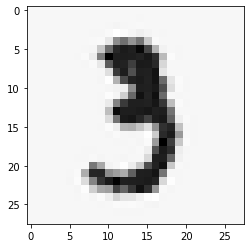

In [7]:
# Example 1.
show_data(X_train, Y_train,10,+10) #x: x데이터, y: 레이블데이터(3,1~),n: 행 넘버, +10: 10도의 각도로 회점

3


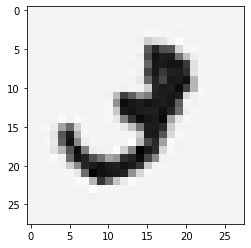

In [8]:
# Example 2.
show_data(X_train, Y_train,10,-30)  #왼쪽으로 30도 회전

1


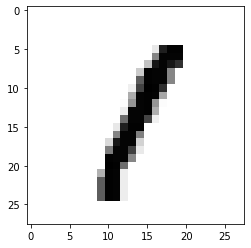

In [9]:
# Example 3.
show_data(X_train, Y_train,77,0)

이렇게 시각화해주는 함수 만듬

### 2) 알고리즘 선택해 예측 분석 실시

- Optimize the hyperparameter(s).
- Calculate the accuracy.
- Is the accuracy high enough?<br>

하이퍼 파라미터 계산해 최적화해서 정확도 계산해보기<br>

결과를 보면 정확도가 낮게 나오는데 이걸 어떻게 향상시킬까?<br>

정확도가 낮게 나온 이유는 오버피팅 때문<br>

변수의 개수를 줄이기보다는 데이터 개수를 늘려서 오버피팅 상황을 완화해보자<br>

학습을 시킬 때 원본과 회전한 데이터 모두 1로 인식하게 해야함<br>
이미지이기 때문에 각도를 늘리면 됨<br>

즉, 이미지이기 때문에 회전만으로 다양하게 학습시킬 수 있음<br>

100개 데이터를 다양한 각도를 실행해서 500개 각도로 학습시켜라<br>

데이터가 적다는 것은 행이 적은 것임

In [10]:
estimator_grid = np.arange(30, 101, 10)  #30~101개의 그루 사용
depth_grid = np.arange(20, 51, 2)        #깊이
parameters = {'n_estimators': estimator_grid, 'max_depth': depth_grid}  #딕셔너리로 만듬
gridCV = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=10) 
gridCV.fit(X_train, Y_train)
best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']

In [11]:
print("Random Forest best n estimator : " + str(best_n_estim))
print("Random Forest best depth : " + str(best_depth))

#최적화된 나무의 개수
#만약에 30~50까지 했을 때 60에 최적화가 속해있으면 결과가 제대로 안나올 수도 있음

Random Forest best n estimator : 90
Random Forest best depth : 34


In [12]:
RF_best = RandomForestClassifier(max_depth=best_depth,n_estimators=best_n_estim,random_state=3)
RF_best.fit(X_train, Y_train);
Y_pred = RF_best.predict(X_test)
print( "Random Forest best accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

#100개데이터에 관측치는 700개니 오버피팅되어 정확도 낮게 나옴

Random Forest best accuracy : 0.71


### 3) 주어진 각 관측값을 각도로 회전시키는 도우미 함수 'rotate_data ()'를 코딩
#### HINT: use scipy.ndimage.interpolation().

In [13]:
def rotate_data(X, angle=0):
    image_matrix = X.reshape((28,28))
    image_matrix = rotate(image_matrix, angle, cval=0.01, reshape=False)
    imax = image_matrix.max()
    imin = image_matrix.min()
    image_matrix = ((image_matrix-imin)/(imax-imin))*0.99+0.01
    return image_matrix.reshape((1,-1))

#여기서는 imshow사용하지 않음

### 4) Augment the training dataset: 데이터 확장
- Increase the size of the training dataset by introducing slight rotations (clockwise and counterclockwise).
- Use the 'rotate_data()' function defined in the previous step.
- No need to augment the testing dataset.
- Target approximately five fold aumentation.

트레이닝 데이터 셋의 크기를 키워 
로테이션 함수로 예측을 다시해서 예측성능이 향상됬는지 확인

In [14]:
N_rows = X_train.shape[0]   #행의 수
N_cols = X_train.shape[1]   #열의 수
X_train_aug = np.empty((0,N_cols))
Y_train_aug = np.array([])  #비어있는 배열 준비
for angle in [-10,-5,0,5,10]:     #-10도 ~ 10도로 재설정해봄
    for n in range(N_rows):
        a_row = X_train[n,:]  #하나의 행을 x로 가져오고 
        a_y = Y_train[n]      #Y로 가져오고 
        X_train_aug = np.concatenate((X_train_aug,rotate_data(a_row,angle)),axis=0) #각도대로 돌려서 이전것과 세로방향으로 이어붙임
        Y_train_aug = np.append(Y_train_aug, a_y)

### 5) 확장된 훈련 데이터셋으로 예측 분석 재실시

- Use the same algorithm as in the step 2).
- Calculate the accuracy.
- Has the accuracy gone up?

In [15]:
#확장된 데이터로 재계산
RF_best = RandomForestClassifier(max_depth=best_depth,n_estimators=best_n_estim,random_state=123)
RF_best.fit(X_train_aug, Y_train_aug);
Y_pred = RF_best.predict(X_test)
print( "Random Forest accuracy with the aumented training data : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Random Forest accuracy with the aumented training data : 0.74
